In [24]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo
import seaborn as sns
from eikonax import derivator, preprocessing, solver, tensorfield
from ls_prior import builder
from matplotlib.colors import Normalize
from mpi4py import MPI

from cardiac_electrophysiology import fibertensor, pts_map
from cardiac_electrophysiology.ls_bip import components, posterior
from cardiac_electrophysiology.utils import data_processing as dp

sns.set_theme(style="ticks")

In [ ]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [50, 50],
    dlx.mesh.CellType.triangle,
)
vertices = mesh.geometry.x[:, :2]
simplices = mesh.geometry.dofmap
num_simplices = simplices.shape[0]
simplex_to_vertex_matrix = dp.assemble_simplex_to_vertex_interpolation_matrix(simplices)
vertex_to_simplex_matrix = dp.assemble_vertex_to_simplex_interpolation_matrix(simplices)

num_observations = 200
noise_var = 1e-5
mean_angle_vector = np.full(simplices.shape[0], 1 / 4 * np.pi)
mean_angle_vector = simplex_to_vertex_matrix @ mean_angle_vector
mean_parameter_vector = np.arctanh(np.cos(mean_angle_vector + np.pi / 2))
ground_truth_parameter_vector = mean_parameter_vector / 3
centered_ground_truth_parameter_vector = ground_truth_parameter_vector - mean_parameter_vector
ground_truth_angle = (
    np.arccos(np.tanh(centered_ground_truth_parameter_vector)) + mean_angle_vector - np.pi / 2
)
first_basis_vector = np.repeat([[1, 0]], num_simplices, axis=0)
second_basis_vector = np.repeat([[0, 1]], num_simplices, axis=0)
longitudinal_velocity_vector = np.full(num_simplices, 3)
transversal_velocity_vector = np.full(num_simplices, 1)
initial_site_ind = np.where((vertices[:, 0] == 0) & (vertices[:, 1] == 0))[0][0]

In [3]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_parameter_vector,
    kappa=1,
    tau=1,
    seed=0,
)
fiber_tensor_settings = fibertensor.FiberTensorSettings(
    dimension=2,
    mean_angle_vector=mean_angle_vector,
    basis_vectors_one=first_basis_vector,
    basis_vectors_two=second_basis_vector,
    longitudinal_velocities=longitudinal_velocity_vector,
    transversal_velocities=transversal_velocity_vector,
)
eikonax_solver_settings = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    max_value=1000,
    loop_type="jitted_while",
    use_soft_update=True,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)
eikonax_derivator_settings = derivator.PartialDerivatorData(
    use_soft_update=True,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)

In [4]:
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

fiber_tensor = fibertensor.FiberTensor(fiber_tensor_settings)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field_object = tensorfield.TensorField(
    num_simplices=num_simplices,
    vector_to_simplices_map=tensor_field_mapping,
    simplex_tensor=fiber_tensor,
)

initial_sites = preprocessing.InitialSites(inds=(initial_site_ind,), values=(0,))
mesh_data = preprocessing.MeshData(mesh.geometry.x[:, :2], mesh.geometry.dofmap)
eikonax_solver = solver.Solver(mesh_data, eikonax_solver_settings, initial_sites)
eikonax_derivator = derivator.PartialDerivator(mesh_data, eikonax_derivator_settings, initial_sites)

eikonal_pts_map = pts_map.EikonalPTSMap(
    eikonax_solver,
    eikonax_derivator,
    tensor_field_object,
    vertex_to_simplex_matrix,
    simplex_to_vertex_matrix,
)

In [5]:
prior_mean_solution = eikonal_pts_map.evaluate_forward(mean_parameter_vector)
ground_truth_solution = eikonal_pts_map.evaluate_forward(ground_truth_parameter_vector)

rng = np.random.default_rng(seed=0)
noise = rng.normal(loc=0.0, scale=np.sqrt(noise_var), size=vertices.shape[0])
noisy_solution = ground_truth_solution + noise
observation_inds = rng.integers(low=0, high=vertices.shape[0], size=num_observations)
observations = noisy_solution[observation_inds]

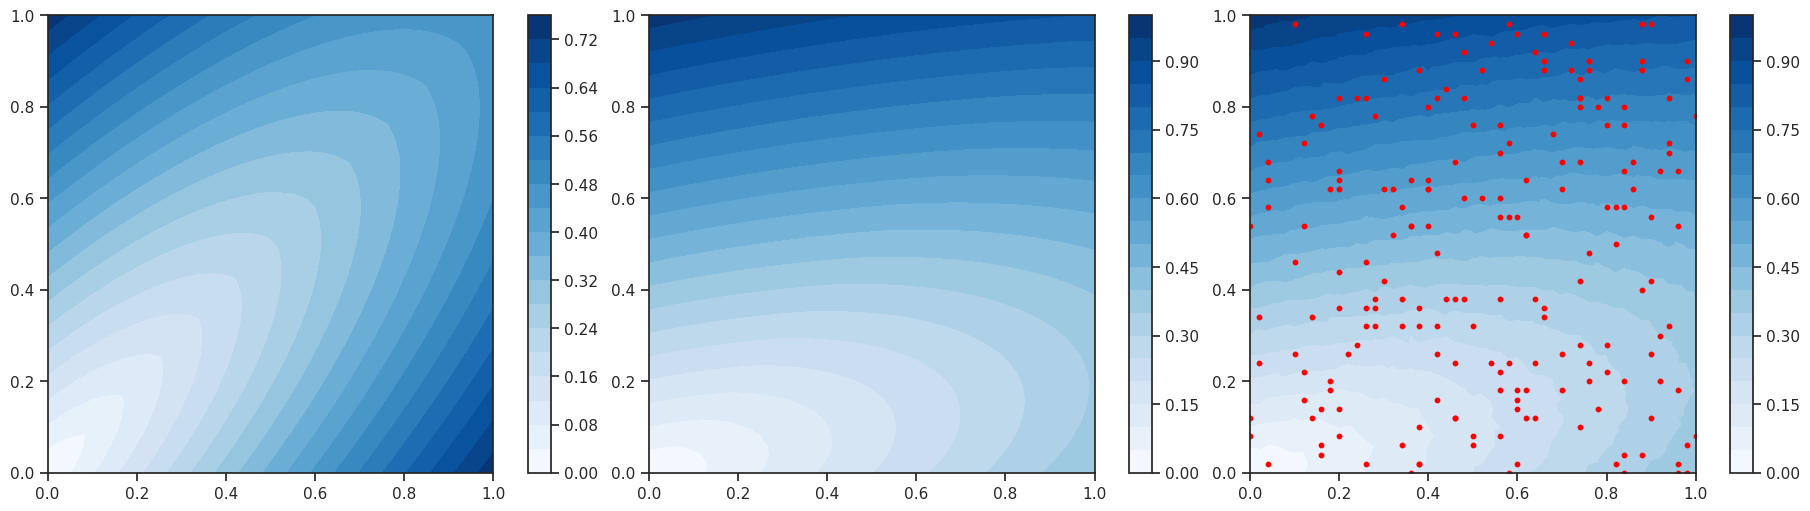

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0], vertices[:, 1], prior_mean_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[0])
contour_plot = axs[1].tricontourf(
    vertices[:, 0], vertices[:, 1], ground_truth_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[1])
contour_plot = axs[2].tricontourf(
    vertices[:, 0], vertices[:, 1], noisy_solution, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[2])
axs[2].scatter(
    vertices[observation_inds, 0],
    vertices[observation_inds, 1],
    c="red",
    s=10,
)


In [7]:
precision_values = np.full(num_observations, 1 / noise_var)
observation_matrix = components.assemble_vertex_observation_matrix(
    vertices.shape[0], observation_inds
)
noise_precision_matrix = components.assemble_diagonal_precision_matrix(precision_values)

log_likelihood = components.GaussianLogLikelihood(
    observations, observation_matrix, noise_precision_matrix
)
log_posterior = posterior.LogPosterior(log_likelihood, eikonal_pts_map, bilaplace_prior)

In [8]:
cost = log_posterior.evaluate_cost(ground_truth_parameter_vector)
gradient = log_posterior.evaluate_gradient(ground_truth_parameter_vector)

======== Cost Evaluation ========
Parameter_vector in: [-0.29379119567318096, -0.29379119567318096]
prior_cost: 0.1726265333102166
likelihood_cost: 92.46433555354744
 
======== Gradient Evaluation ========
Parameter_vector in: [-0.29379119567318096, -0.29379119567318096]
likelihood_gradient in: [-868.7278756063564, 951.0726781232214]
pts_gradient in: [-5.090776507029828, 22.566118329691815]
prior_gradient in: [3.9172157063949165e-05, 0.00023503296708748955]


In [12]:
optimizer_options = {
    "disp": True,
    "maxiter": 1000,
    "ftol": 1e-6,
    "gtol": 1e-6,
    "maxls": 100,
}

map_estimate = spo.minimize(
    fun=log_posterior.evaluate_cost,
    jac=log_posterior.evaluate_gradient,
    x0=mean_parameter_vector,
    method="L-BFGS-B",
    options=optimizer_options,
)

======== Cost Evaluation ========
Parameter_vector in: [-0.8813735870195429, -0.8813735870195429]
prior_cost: 0.0
likelihood_cost: 493681.88644513575
 
======== Gradient Evaluation ========
Parameter_vector in: [-0.8813735870195429, -0.8813735870195429]
likelihood_gradient in: [-72771.335174548, 34186.0710488157]
pts_gradient in: [-10898.083228240588, 469.4751397324673]
prior_gradient in: [0.0, 0.0]
======== Cost Evaluation ========
Parameter_vector in: [-0.894741935883432, -0.5710496396730642]
prior_cost: 1245.6932875536663
likelihood_cost: 445380.49930680817
 
======== Gradient Evaluation ========
Parameter_vector in: [-0.894741935883432, -0.5710496396730642]
likelihood_gradient in: [-71722.23978232083, 30489.36713798806]
pts_gradient in: [-19962.18155756824, 358.6642867577748]
prior_gradient in: [-4555.360937006596, 4281.514151739905]
======== Cost Evaluation ========
Parameter_vector in: [-0.9482153313389884, 0.6702461497128505]
prior_cost: 31142.332188841625
likelihood_cost: 31790

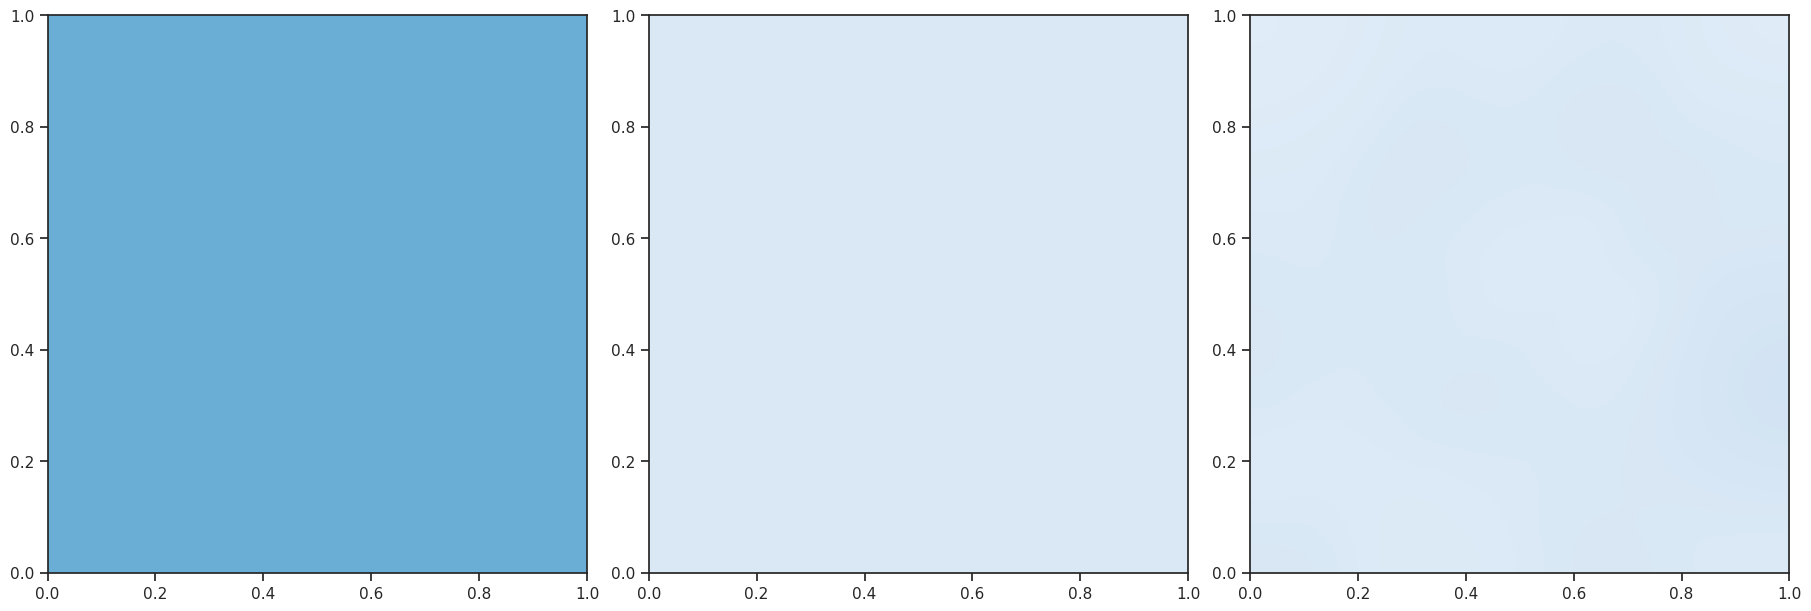

In [34]:
posterior_centered_parameter_vector = map_estimate.x - mean_parameter_vector
posterior_angle = (
    np.arccos(np.tanh(posterior_centered_parameter_vector)) + mean_angle_vector - np.pi / 2
)

color_norm = Normalize(vmin=0, vmax=90)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0],
    vertices[:, 1],
    np.degrees(mean_angle_vector),
    levels=20,
    cmap="Blues",
    norm=color_norm,
)
contour_plot = axs[1].tricontourf(
    vertices[:, 0],
    vertices[:, 1],
    np.degrees(ground_truth_angle),
    levels=20,
    cmap="Blues",
    norm=color_norm,
)
contour_plot = axs[2].tricontourf(
    vertices[:, 0],
    vertices[:, 1],
    np.degrees(posterior_angle),
    levels=20,
    cmap="Blues",
    norm=color_norm,
)

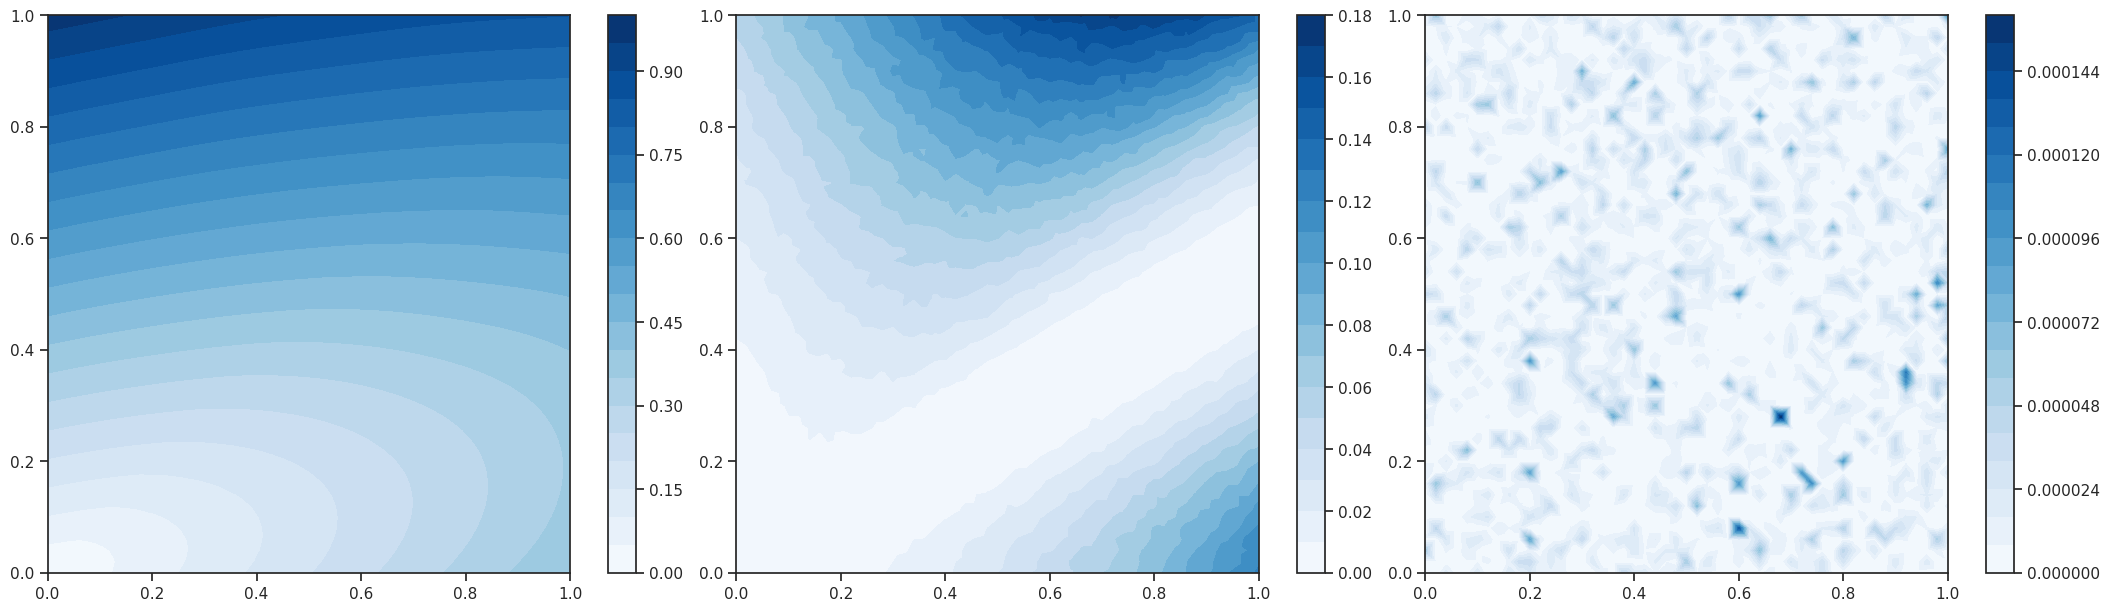

In [ ]:
posterior_predictive = eikonal_pts_map.evaluate_forward(map_estimate.x)
prior_mean_diff = np.square(prior_mean_solution - noisy_solution)
posterior_diff = np.square(posterior_predictive - noisy_solution)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0], vertices[:, 1], posterior_predictive, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[0])
contour_plot = axs[1].tricontourf(
    vertices[:, 0], vertices[:, 1], prior_mean_diff, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[1])
contour_plot = axs[2].tricontourf(
    vertices[:, 0], vertices[:, 1], posterior_diff, levels=20, cmap="Blues"
)

plt.colorbar(contour_plot, ax=axs[2])
